In [1]:
import requests
import io
from bs4 import BeautifulSoup as BS
import pandas as pd
import sys
import time
from datetime import date,datetime,timedelta
import random
import numpy as np
from PIL import Image as IM
import pytesseract
import os
import cv2
import re
import asyncio
import hangups
from scipy.misc import toimage
from sklearn import preprocessing

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
from keras.models import model_from_json
from keras.utils import np_utils

Using Theano backend.


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
class captcha_recognize:
    def __init__(self):
        self.model = None
        self.lable = ['1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D',
       'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R',
       'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
    def one_hot_reverse(self,onehot):
        return self.lable[np.where(onehot==1)[0][0]]
    def load_model(self):
        self.model = model_from_json(open('TPEX_cnn_captcha.json').read())
        self.model.load_weights('TPEX_captcha_weights.h5')

        sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
        self.model.compile(loss='categorical_crossentropy',
                      optimizer=sgd,
                      metrics=['accuracy'])
    def preprocess(self,image):
        X = []
        imgpos = [[0,32],[25,57],[49,81],[72,104],[98,130]]
        #image = IM.open('/home/ubuntu/Notebooks/captest.png')
        imgarray = np.asarray(image.convert(mode='RGB'))
        #print(imgarray.shape)
        for tid in range(5):
            X.append(imgarray[:,imgpos[tid][0]:imgpos[tid][1]].reshape(3,32,30))
        X = np.array(X).astype('float32')
        X /= 255
        return X
    
    def captcha_predict(self,X):
        if type(self.model)!= Sequential:
            self.load_model()
        ans = self.model.predict(X)
        captcha =''
        for i in ans:
            captcha += self.lable[i.argmax()]
        return captcha

In [ ]:
captcha_rec = captcha_recognize()

In [ ]:
captcha_rec.captcha_predict(captcha_rec.preprocess(IM.open(io.BytesIO(captc.content))))

In [6]:
class TPEXBSreport:
    def __init__(self):
        self.rs = requests.session()
        self.curpath = ''
        self.datenow = self.__getdate()
        self.notradedata = []#new
        stockidt = pd.read_csv(self.curpath+'csv_data/listcompanyo.csv',encoding='utf-8')
        self.stockidL = stockidt['股票代號'].tolist()
        self.captcha_rec = captcha_recognize()
    def __getdate(self):
        d = datetime.now()
        if d.hour<16:
            d = d.date() - timedelta(1)
        if type(d) != type(date.today()):
                d = d.date()
        if d.isoweekday() == 7:
            d = d - timedelta(2)
        elif d.isoweekday() == 6:
            d = d - timedelta(1)
        return d
    def getCaptcha(self):
        sleeptime = 30
        captcha = None
        while str(captcha) != '<Response [200]>':
            try:
                captcha = self.rs.get('http://www.tpex.org.tw/web/inc/authnum.php',stream=True, verify=False)
            except:
                time.sleep(sleeptime)
                sleeptime+=300
        return captcha.content

        
    def OCR(self):
        return self.captcha_rec.captcha_predict(self.captcha_rec.preprocess(IM.open(io.BytesIO(self.getCaptcha()))))
    
            
    def postpayload(self,stockid,captcha,urltype):
        payload = {
            'stk_code': '%s'%str(stockid),
            'auth_num':captcha
        }
        res = self.rs.post('http://www.tpex.org.tw/web/stock/aftertrading/broker_trading/brokerBS.php',data = payload)
        res.encoding = 'utf-8'
        soup = BS(res.text,"lxml")
        self.answ = soup.select('.pt10')[0].text  
        if self.answ == '\n ***驗證碼錯誤，請重新查詢。*** \n':
            correctanswer = 0
        elif self.answ == '\n ***該股票該日無交易資訊*** \n':
            return 2
        elif self.answ[0:7] == '\n\n\n交易日期':
            correctanswer = 1
            #self.savecorimg(captcha)
            self.ind = pd.read_html(str(soup.select('.table-striped')[0]))[0]
            self.dtda = re.sub('[^0-9]','/',self.ind[1][0]).split('/')[0:3]
            stkd = ('').join(self.dtda)
            urlbig5 = 'http://www.tpex.org.tw/web/stock/aftertrading/broker_trading/download_ALLCSV.php?curstk='
            urlutf8 = 'http://www.tpex.org.tw/web/stock/aftertrading/broker_trading/download_ALLCSV_UTF-8.php?curstk='
            if urltype == 5:
                url = urlbig5+str(stockid)+'&stk_date='+stkd+'&auth='+captcha
            elif urltype ==8:
                url = urlutf8+str(stockid)+'&stk_date='+stkd+'&auth='+captcha
            self.csvf = self.rs.get(url,stream=True, verify=False)
        else:
            correctanswer = 0
        return correctanswer
    
    def processdata(self,stockid):
        dat = date(int(self.dtda[0])+1911,int(self.dtda[1]),int(self.dtda[2]))
        tda = int(self.ind[1][1])
        ap = int(re.sub('[^0-9]','',self.ind[3][1]))
        allshare = self.ind[5][1]
        rt_ratio = self.ind[7][1]
        op = float(self.ind[1][2])
        hp = float(self.ind[3][2])
        lp = float(self.ind[5][2])
        cp = float(self.ind[7][2])
        d = {"日期":dat,
             "代號":stockid,
             "成交筆數":tda,
             "總成交金額":ap,
             "總成交股數":allshare,
             "周轉率(%)":rt_ratio,
             "開盤價":op,
             "最高價":hp,
             "最低價":lp,
             "收盤價":cp}
        ind = pd.DataFrame(d, index=[1])
        ind.index.name = '序號'
        tablens = pd.read_csv(io.StringIO(self.csvf.text.split('證券代碼')[1][7:]),encoding='utf-8')
        table00 = tablens[['序號','券商','價格','買進股數','賣出股數']]
        table01 = tablens[['序號.1','券商.1','價格.1','買進股數.1','賣出股數.1']]
        table00.columns = ['序號','證券商','成交單價','買進股數','賣出股數']
        table01.columns = ['序號','證券商','成交單價','買進股數','賣出股數']
        frame00 = [table00,table01]
        table = pd.concat(frame00)
        table = table.set_index('序號')
        table = table.dropna()
        table = table.sort_index()
        table.index.name = '序'
        table['買進股數'] = table['買進股數'].map(lambda x: getint(x))
        table['賣出股數'] = table['賣出股數'].map(lambda x: getint(x))
        table = table.join(ind)
        table[["日期","代號","成交筆數","總成交金額","總成交股數","周轉率(%)","開盤價","最高價","最低價","收盤價"]] = table[["日期","代號","成交筆數","總成交金額","總成交股數","周轉率(%)","開盤價","最高價","最低價","收盤價"]].fillna(method='pad')
        table = table[["日期","代號","成交筆數","總成交金額","總成交股數","周轉率(%)","開盤價","最高價","最低價","收盤價","證券商","成交單價","買進股數","賣出股數"]]
        table['日期'] = pd.to_datetime(table['日期'])
        filename = str(stockid)+"_"+('').join(str(dat).split('-'))
        table.to_csv(self.curpath+'csv_data/stockdt/ori/%s.csv'%filename)
        #######################################################################################
        buyp = table.apply(lambda row: row['成交單價']*row['買進股數'],axis=1)
        table.insert(13,'買進金額',buyp)
        sellp = table.apply(lambda row: row['成交單價']*row['賣出股數'],axis=1)
        table.insert(14,'賣出金額',sellp)
        table_sort = table.groupby(["日期","代號","成交筆數","總成交金額","總成交股數","周轉率(%)","開盤價","最高價","最低價","收盤價","證券商"])[['買進股數','賣出股數','買進金額','賣出金額']].sum()
        table_sort = table_sort.reset_index(["成交筆數","總成交金額","總成交股數","周轉率(%)","開盤價","最高價","最低價","收盤價"])
        table_sort = table_sort[['買進股數','賣出股數','買進金額','賣出金額',"成交筆數","總成交金額","總成交股數","周轉率(%)","開盤價","最高價","最低價","收盤價"]]
        b_avg_p = table_sort.apply(lambda row: divexpectz(row['買進金額'],row['買進股數']),axis=1)
        s_avg_p = table_sort.apply(lambda row: divexpectz(row['賣出金額'],row['賣出股數']),axis=1)
        b_ratio = table_sort.apply(lambda row: divexpectz(row['買進股數'],row['總成交股數'])*100,axis=1)
        s_ratio = table_sort.apply(lambda row: divexpectz(row['賣出股數'],row['總成交股數'])*100,axis=1)
        bs_share_net = table_sort.apply(lambda row: row['買進股數']-row['賣出股數'],axis=1)
        bs_price_net = table_sort.apply(lambda row: row['買進金額']-row['賣出金額'],axis=1)
        table_sort.insert(2,'買賣超股數',bs_share_net)
        table_sort.insert(5,'買賣超金額',bs_price_net)
        table_sort.insert(6,'買進均價',b_avg_p)
        table_sort.insert(7,'賣出均價',s_avg_p)
        table_sort.insert(8,'買進比重',b_ratio)
        table_sort.insert(9,'賣出比重',s_ratio)
        if os.path.exists(self.curpath+'csv_data/stockdt/sort/%s.csv'%str(stockid)) == False:
            table_sort.to_csv(self.curpath+'csv_data/stockdt/sort/%s.csv'%str(stockid))
        #after first time use
        table_s = pd.read_csv(self.curpath+'csv_data/stockdt/sort/%s.csv'%str(stockid),encoding='utf-8',index_col=[0,1,2],parse_dates=[0])
        if dat not in table_s.index.levels[0]:
            frame = [table_sort,table_s]
            table_s = pd.concat(frame)
        table_s.to_csv(self.curpath+'csv_data/stockdt/sort/%s.csv'%str(stockid))
    
    def singleprocess(self,stockid):
        anscor = 0
        repostcount = 0
        changeurltype = 0
        filename = str(stockid)+"_"+('').join(str(self.datenow).split('-'))
        if os.path.exists(self.curpath+'csv_data/stockdt/ori/%s.csv'%filename) == False:
            while anscor == 0:
                if changeurltype ==0:
                    urltype = 5
                elif changeurltype==1:
                    urltype = 8
                Capt = ''
                while len(Capt) !=5:
                    try:
                        Capt = self.OCR()
                    except:
                        pass
                anscor = self.postpayload(stockid, Capt,urltype)
                returnstat(stockid,repostcount)
                repostcount +=1
                if anscor == 2:
                    self.notradedata.append(stockid)
                    break
                if repostcount>150:
                    repostcount = 150
                    break
                time.sleep(random.choice([2.8,3.2,3.8,4.1,4.7]))
                while anscor == 1 and int(self.dtda[0])<85:
                    anscor = self.postpayload(stockid, Capt, urltype)
                    time.sleep(random.choice([1.3,1.8,1.4,1.1,1.5]))
                if anscor == 1 and int(self.dtda[0])>85:
                    try:
                        self.processdata(stockid)
                        changeurltype = 0
                    except:
                        changeurltype = 1
                        anscor = 0
        if os.path.exists(self.curpath+'csv_data/stockdt/ori/%s.csv'%filename) == True:
            repostcount = 100
        return stockid,repostcount
    
    def processAll(self):
        starttime = datetime.now()
        stlen = len(self.stockidL)
        self.arrcu = []
        global MESSAGE
        MESSAGE = ''
        for i in range(stlen):
            a = self.singleprocess(self.stockidL[i])
            if a[1]==150:
                a = self.singleprocess(self.stockidL[i])
            ptime = datetime.now()
            text = "\r上櫃 {0}/{1} 已完成 {2}%  處理時間: {3}".format(i+1,stlen,round((i+1)/stlen,4)*100,str(ptime-starttime))
            sys.stdout.write(text)
            sys.stdout.flush()
            #MESSAGE = "上櫃 {0}/{1} 已完成 {2}%  處理時間: {3}".format(i+1,stlen,round((i+1)/stlen,4)*100,str(ptime-starttime))
            #Hangouts()
            self.arrcu.append(a)
            if self.arrcu[-1][1] == 0:
                time.sleep(3)
            if len(self.arrcu)>3 and self.arrcu[-1][1] == 0 and self.arrcu[-2][1] == 0 and self.arrcu[-3][1] == 0:
                time.sleep(5)
        endtime = datetime.now()
        spendt = str(endtime - starttime)
        MESSAGE = "上櫃股票交易日報下載完成 \n 花費時間:{0}".format(spendt)
        Hangouts()
    
    def checkunprocesslist(self):
        datestr = ('').join(str(self.datenow).split('-'))+'.csv'
        fprocessed = [int(i.split('_')[0]) for i in os.listdir('csv_data/stockdt/ori') if i.endswith(datestr)==True] + self.notradedata
        self.unprocess = [i for i in self.stockidL if i not in fprocessed]
        return round(len(self.unprocess)/len(self.stockidL),4)*100,len(self.unprocess),len(self.stockidL)

In [5]:
def getint(x):
    if type(x) == str:
        return int(('').join(x.split(',')))
    else:
        return x
def divexpectz(a,b):
    if b == 0:
        return 0
    else:
        return round(a/b,2)
def returnstat(id0,reposttime):
    text = "\r {0}重新取得驗證碼次數:{1}".format(id0,reposttime)
    sys.stdout.write(text)
    sys.stdout.flush()

refpath = ''#os.getcwd()+'/'
CONVERSATION_ID = 'Ugx10p7pgNA_uogOqn54AaABAagB3ZWGCA'
REFRESH_TOKEN_PATH = refpath+'refresh_token.txt'
    
def Hangouts():
    cookies = hangups.auth.get_auth_stdin(REFRESH_TOKEN_PATH)
    client = hangups.Client(cookies)
    client.on_connect.add_observer(lambda: asyncio.async(send_message(client)))
    loop = asyncio.get_event_loop()
    loop.run_until_complete(client.connect())
@asyncio.coroutine
def send_message(client):
    """Send message using connected hangups.Client instance."""
    request = hangups.hangouts_pb2.SendChatMessageRequest(
        request_header=client.get_request_header(),
        event_request_header=hangups.hangouts_pb2.EventRequestHeader(
            conversation_id=hangups.hangouts_pb2.ConversationId(id=CONVERSATION_ID),
            client_generated_id=client.get_client_generated_id(),),
        message_content=hangups.hangouts_pb2.MessageContent(
            segment=[hangups.ChatMessageSegment(MESSAGE).serialize()],),)
    try:
        yield from client.send_chat_message(request)
    finally:
        yield from client.disconnect()
    
    
class TPEXBSreport:
    def __init__(self):
        self.rs = requests.session()
        self.curpath = ''
        self.datenow = self.__getdate()
        self.notradedata = []#new
        stockidt = pd.read_csv(self.curpath+'csv_data/listcompanyo.csv',encoding='utf-8')
        self.stockidL = stockidt['股票代號'].tolist()
    def __constr(self,l):
        an = re.sub('[^A-Z0-9]','',l.upper())
        if len(an) > 5:
            an = re.sub('[^A-HJ-Z0-9]','',l.upper())
        if '0' in an:
            an = an.replace('0','Q')
        if 'O' in an:
            an = an.replace('O','Q')
        return an
    def __getdate(self):
        d = datetime.now()
        if d.hour<16:
            d = d.date() - timedelta(1)
        if type(d) != type(date.today()):
                d = d.date()
        if d.isoweekday() == 7:
            d = d - timedelta(2)
        elif d.isoweekday() == 6:
            d = d - timedelta(1)
        return d
    def getCaptcha(self):
        sleeptime = 30
        captcha = None
        while str(captcha) != '<Response [200]>':
            try:
                captcha = self.rs.get('http://www.tpex.org.tw/web/inc/authnum.php',stream=True, verify=False)
            except:
                time.sleep(sleeptime)
                sleeptime+=300
        return captcha.content
    def cv2image(self):
        captchat_byte = self.getCaptcha()
        image_rgb = cv2.imdecode(np.frombuffer(captchat_byte,dtype=np.uint8),flags=1)
        image_gray = cv2.imdecode(np.frombuffer(captchat_byte,dtype=np.uint8),flags=0)
        cv2.imwrite(self.curpath+"ocrcorrect/otcoir/bkcapt.png", image_rgb)
        plt.imshow(image_rgb)
        return image_gray
    def Captcha_preprocess(self):
        image = self.cv2image()
        im = cv2.resize(image, (260,60))
        retval, im = cv2.threshold(im,120, 255, cv2.THRESH_BINARY_INV)
        kernel = np.ones((3,3),np.uint8)
        erosion = cv2.erode(im,kernel,iterations = 1)
        blurred = cv2.GaussianBlur(erosion, (3, 3), 5)
        cv2.imwrite(self.curpath+"bkcapt.png", blurred)
        return 1
        
    def OCR(self):
        return self.__constr(pytesseract.image_to_string(IM.open(self.curpath+'bkcapt.png')))
    
    def savecorimg(self, captcha):
        if os.path.exists(self.curpath+'ocrcorrect/otcoir/%s.png'%captcha)== False:
            os.rename(self.curpath+'ocrcorrect/otcoir/bkcapt.png',
                      self.curpath+'ocrcorrect/otcoir/%s.png'%captcha)
        elif os.path.exists(self.curpath+'ocrcorrect/otcoir/%s.png'%captcha)== True:
            nonew = 1
            npng = captcha+'_'+str(nonew)
            while os.path.exists(self.curpath+'ocrcorrect/otcoir/%s.png'%npng)== True:
                nonew +=1
                npng = captcha+'_'+str(nonew)
            if os.path.exists(self.curpath+'ocrcorrect/otcoir/%s.png'%npng)== False:
                os.rename(self.curpath+'ocrcorrect/otcoir/bkcapt.png',
                          self.curpath+'ocrcorrect/otcoir/%s.png'%npng)
            
    def postpayload(self,stockid,captcha,urltype):
        payload = {
            'stk_code': '%s'%str(stockid),
            'auth_num':captcha
        }
        res = self.rs.post('http://www.tpex.org.tw/web/stock/aftertrading/broker_trading/brokerBS.php',data = payload)
        res.encoding = 'utf-8'
        soup = BS(res.text,"lxml")
        self.answ = soup.select('.pt10')[0].text  
        if self.answ == '\n ***驗證碼錯誤，請重新查詢。*** \n':
            correctanswer = 0
        elif self.answ == '\n ***該股票該日無交易資訊*** \n':
            return 2
        elif self.answ[0:7] == '\n\n\n交易日期':
            correctanswer = 1
            self.savecorimg(captcha)
            self.ind = pd.read_html(str(soup.select('.table-striped')[0]))[0]
            self.dtda = re.sub('[^0-9]','/',self.ind[1][0]).split('/')[0:3]
            stkd = ('').join(self.dtda)
            urlbig5 = 'http://www.tpex.org.tw/web/stock/aftertrading/broker_trading/download_ALLCSV.php?curstk='
            urlutf8 = 'http://www.tpex.org.tw/web/stock/aftertrading/broker_trading/download_ALLCSV_UTF-8.php?curstk='
            if urltype == 5:
                url = urlbig5+str(stockid)+'&stk_date='+stkd+'&auth='+captcha
            elif urltype ==8:
                url = urlutf8+str(stockid)+'&stk_date='+stkd+'&auth='+captcha
            self.csvf = self.rs.get(url,stream=True, verify=False)
        else:
            correctanswer = 0
        return correctanswer
    
    def processdata(self,stockid):
        dat = date(int(self.dtda[0])+1911,int(self.dtda[1]),int(self.dtda[2]))
        tda = int(self.ind[1][1])
        ap = int(re.sub('[^0-9]','',self.ind[3][1]))
        allshare = self.ind[5][1]
        rt_ratio = self.ind[7][1]
        op = float(self.ind[1][2])
        hp = float(self.ind[3][2])
        lp = float(self.ind[5][2])
        cp = float(self.ind[7][2])
        d = {"日期":dat,
             "代號":stockid,
             "成交筆數":tda,
             "總成交金額":ap,
             "總成交股數":allshare,
             "周轉率(%)":rt_ratio,
             "開盤價":op,
             "最高價":hp,
             "最低價":lp,
             "收盤價":cp}
        ind = pd.DataFrame(d, index=[1])
        ind.index.name = '序號'
        tablens = pd.read_csv(io.StringIO(self.csvf.text.split('證券代碼')[1][7:]),encoding='utf-8')
        table00 = tablens[['序號','券商','價格','買進股數','賣出股數']]
        table01 = tablens[['序號.1','券商.1','價格.1','買進股數.1','賣出股數.1']]
        table00.columns = ['序號','證券商','成交單價','買進股數','賣出股數']
        table01.columns = ['序號','證券商','成交單價','買進股數','賣出股數']
        frame00 = [table00,table01]
        table = pd.concat(frame00)
        table = table.set_index('序號')
        table = table.dropna()
        table = table.sort_index()
        table.index.name = '序'
        table['買進股數'] = table['買進股數'].map(lambda x: getint(x))
        table['賣出股數'] = table['賣出股數'].map(lambda x: getint(x))
        table = table.join(ind)
        table[["日期","代號","成交筆數","總成交金額","總成交股數","周轉率(%)","開盤價","最高價","最低價","收盤價"]] = table[["日期","代號","成交筆數","總成交金額","總成交股數","周轉率(%)","開盤價","最高價","最低價","收盤價"]].fillna(method='pad')
        table = table[["日期","代號","成交筆數","總成交金額","總成交股數","周轉率(%)","開盤價","最高價","最低價","收盤價","證券商","成交單價","買進股數","賣出股數"]]
        table['日期'] = pd.to_datetime(table['日期'])
        filename = str(stockid)+"_"+('').join(str(dat).split('-'))
        table.to_csv(self.curpath+'csv_data/stockdt/ori/%s.csv'%filename)
        #######################################################################################
        buyp = table.apply(lambda row: row['成交單價']*row['買進股數'],axis=1)
        table.insert(13,'買進金額',buyp)
        sellp = table.apply(lambda row: row['成交單價']*row['賣出股數'],axis=1)
        table.insert(14,'賣出金額',sellp)
        table_sort = table.groupby(["日期","代號","成交筆數","總成交金額","總成交股數","周轉率(%)","開盤價","最高價","最低價","收盤價","證券商"])[['買進股數','賣出股數','買進金額','賣出金額']].sum()
        table_sort = table_sort.reset_index(["成交筆數","總成交金額","總成交股數","周轉率(%)","開盤價","最高價","最低價","收盤價"])
        table_sort = table_sort[['買進股數','賣出股數','買進金額','賣出金額',"成交筆數","總成交金額","總成交股數","周轉率(%)","開盤價","最高價","最低價","收盤價"]]
        b_avg_p = table_sort.apply(lambda row: divexpectz(row['買進金額'],row['買進股數']),axis=1)
        s_avg_p = table_sort.apply(lambda row: divexpectz(row['賣出金額'],row['賣出股數']),axis=1)
        b_ratio = table_sort.apply(lambda row: divexpectz(row['買進股數'],row['總成交股數'])*100,axis=1)
        s_ratio = table_sort.apply(lambda row: divexpectz(row['賣出股數'],row['總成交股數'])*100,axis=1)
        bs_share_net = table_sort.apply(lambda row: row['買進股數']-row['賣出股數'],axis=1)
        bs_price_net = table_sort.apply(lambda row: row['買進金額']-row['賣出金額'],axis=1)
        table_sort.insert(2,'買賣超股數',bs_share_net)
        table_sort.insert(5,'買賣超金額',bs_price_net)
        table_sort.insert(6,'買進均價',b_avg_p)
        table_sort.insert(7,'賣出均價',s_avg_p)
        table_sort.insert(8,'買進比重',b_ratio)
        table_sort.insert(9,'賣出比重',s_ratio)
        if os.path.exists(self.curpath+'csv_data/stockdt/sort/%s.csv'%str(stockid)) == False:
            table_sort.to_csv(self.curpath+'csv_data/stockdt/sort/%s.csv'%str(stockid))
        #after first time use
        table_s = pd.read_csv(self.curpath+'csv_data/stockdt/sort/%s.csv'%str(stockid),encoding='utf-8',index_col=[0,1,2],parse_dates=[0])
        if dat not in table_s.index.levels[0]:
            frame = [table_sort,table_s]
            table_s = pd.concat(frame)
        table_s.to_csv(self.curpath+'csv_data/stockdt/sort/%s.csv'%str(stockid))
    
    def singleprocess(self,stockid):
        anscor = 0
        repostcount = 0
        changeurltype = 0
        filename = str(stockid)+"_"+('').join(str(self.datenow).split('-'))
        if os.path.exists(self.curpath+'csv_data/stockdt/ori/%s.csv'%filename) == False:
            while anscor == 0:
                if changeurltype ==0:
                    urltype = 5
                elif changeurltype==1:
                    urltype = 8
                Capt = 0
                while Capt ==0:
                    try:
                        Capt = self.Captcha_preprocess()
                    except:
                        pass
                anscor = self.postpayload(stockid, self.OCR(),urltype)
                returnstat(stockid,repostcount)
                repostcount +=1
                if anscor == 2:
                    self.notradedata.append(stockid)
                    break
                if repostcount>150:
                    repostcount = 150
                    break
                time.sleep(random.choice([2.8,3.2,3.8,4.1,4.7]))
                while anscor == 1 and int(self.dtda[0])<85:
                    anscor = self.postpayload(stockid, self.OCR(), urltype)
                    time.sleep(random.choice([1.3,1.8,1.4,1.1,1.5]))
                if anscor == 1 and int(self.dtda[0])>85:
                    try:
                        self.processdata(stockid)
                        changeurltype = 0
                    except:
                        changeurltype = 1
                        anscor = 0
        if os.path.exists(self.curpath+'csv_data/stockdt/ori/%s.csv'%filename) == True:
            repostcount = 100
        return stockid,repostcount
    
    def processAll(self):
        starttime = datetime.now()
        stlen = len(self.stockidL)
        self.arrcu = []
        global MESSAGE
        MESSAGE = ''
        for i in range(stlen):
            a = self.singleprocess(self.stockidL[i])
            if a[1]==150:
                a = self.singleprocess(self.stockidL[i])
            ptime = datetime.now()
            text = "\r上櫃 {0}/{1} 已完成 {2}%  處理時間: {3}".format(i+1,stlen,round((i+1)/stlen,4)*100,str(ptime-starttime))
            sys.stdout.write(text)
            sys.stdout.flush()
            #MESSAGE = "上櫃 {0}/{1} 已完成 {2}%  處理時間: {3}".format(i+1,stlen,round((i+1)/stlen,4)*100,str(ptime-starttime))
            #Hangouts()
            self.arrcu.append(a)
            if self.arrcu[-1][1] == 0:
                time.sleep(3)
            if len(self.arrcu)>3 and self.arrcu[-1][1] == 0 and self.arrcu[-2][1] == 0 and self.arrcu[-3][1] == 0:
                time.sleep(5)
        endtime = datetime.now()
        spendt = str(endtime - starttime)
        MESSAGE = "上櫃股票交易日報下載完成 \n 花費時間:{0}".format(spendt)
        Hangouts()
    
    def checkunprocesslist(self):
        datestr = ('').join(str(self.datenow).split('-'))+'.csv'
        fprocessed = [int(i.split('_')[0]) for i in os.listdir('csv_data/stockdt/ori') if i.endswith(datestr)==True] + self.notradedata
        self.unprocess = [i for i in self.stockidL if i not in fprocessed]
        return round(len(self.unprocess)/len(self.stockidL),4)*100,len(self.unprocess),len(self.stockidL)
  

In [7]:
BSr = TPEXBSreport()

In [8]:
BSr.OCR()

'VT89B'

In [9]:
BSr.checkunprocesslist()

(38.58, 277, 718)

In [14]:
BSr.checkunprocesslist()

(35.099999999999994, 252, 718)

In [15]:
BSr.unprocess

[3332,
 3434,
 4907,
 4950,
 5603,
 5604,
 5609,
 5701,
 5703,
 5704,
 5820,
 5878,
 5902,
 5903,
 5904,
 5905,
 6015,
 6016,
 6020,
 6021,
 6022,
 6023,
 6024,
 6026,
 6101,
 6104,
 6105,
 6107,
 6109,
 6111,
 6113,
 6114,
 6118,
 6121,
 6122,
 6123,
 6124,
 6125,
 6126,
 6127,
 6129,
 6130,
 6134,
 6138,
 6140,
 6143,
 6144,
 6146,
 6147,
 6148,
 6150,
 6151,
 6154,
 6156,
 6158,
 6160,
 6161,
 6163,
 6167,
 6169,
 6170,
 6171,
 6173,
 6174,
 6175,
 6179,
 6180,
 6182,
 6185,
 6186,
 6187,
 6188,
 6190,
 6194,
 6195,
 6198,
 6203,
 6204,
 6207,
 6208,
 6210,
 6212,
 6217,
 6218,
 6219,
 6220,
 6221,
 6223,
 6227,
 6228,
 6229,
 6231,
 6233,
 6234,
 6237,
 6238,
 6241,
 6244,
 6245,
 6246,
 6247,
 6248,
 6259,
 6261,
 6263,
 6264,
 6265,
 6266,
 6270,
 6274,
 6275,
 6276,
 6279,
 6284,
 6287,
 6290,
 6291,
 6292,
 6294,
 6298,
 6404,
 6411,
 6417,
 6419,
 6432,
 6435,
 6457,
 6462,
 6465,
 6470,
 6485,
 6488,
 6496,
 6506,
 6508,
 6509,
 6514,
 6603,
 6609,
 6803,
 7402,
 8024,
 8027,

In [7]:
stockid = 3658

In [13]:
stockid = 6250

In [14]:
BSr.singleprocess(stockid)

 6250重新取得驗證碼次數:0

(6250, 1)

In [12]:
BSr.processAll()

上櫃 718/718 已完成 100.0%  處理時間: 0:20:58.669133

In [18]:
BSr.csvf.text

'券商買賣證券成交價量資訊\r\n證券代碼,8349\r\n序號,券商,價格,買進股數,賣出股數,,序號,券商,價格,買進股數,賣出股數\r\n"1","1034  土銀嘉義","79.00","0","1,000",,"2","126D  宏遠台南","79.20","1,000","0"\r\n"3","585Z  統一松江","78.90","1,000","0",,"4","585Z  統一松江","79.10","1,000","0"\r\n"5","585Z  統一松江","79.20","1,000","0",,"6","585Z  統一松江","79.30","1,000","0"\r\n"7","585Z  統一松江","79.40","1,000","0",,"8","585Z  統一松江","79.50","1,000","0"\r\n"9","6163  中信託永康","80.00","0","1,000",,"10","6950  福勝","79.00","10,000","0"\r\n"11","700I  兆豐北高雄","80.00","0","1,000",,"12","703A  致和日陞","80.00","2,000","0"\r\n"13","779c  國票敦北","79.10","2,000","0",,"14","815A  台新高雄","79.40","0","1,000"\r\n"15","8458  康和台南","79.10","0","1,000",,"16","8561  新光台中","79.10","2,000","0"\r\n"17","8847  玉山台南","79.00","6,000","0",,"18","8849  玉山台大","78.90","0","1,000"\r\n"19","9300  華南永昌","79.00","0","3,000",,"20","9300  華南永昌","79.10","0","2,000"\r\n"21","9300  華南永昌","79.50","0","1,000",,"22","9321  永昌佳里","79.00","0","11,000"\r\n"23","9321  永昌佳里","79.10","0","2,000",,"24","9321  永昌佳里

In [17]:
pd.read_csv(io.StringIO(BSr.csvf.text.split('證券代碼')[1][7:]),encoding='utf-8')

,序號,券商,價格,買進股數,賣出股數,Unnamed: 5,序號.1,券商.1,價格.1,買進股數.1,賣出股數.1
0,1,1034 土銀嘉義,79.0,0,"1,000",NaN,2,126D 宏遠台南,79.2,"1,000",0
1,3,585Z 統一松江,78.9,"1,000",0,NaN,4,585Z 統一松江,79.1,"1,000",0
2,5,585Z 統一松江,79.2,"1,000",0,NaN,6,585Z 統一松江,79.3,"1,000",0
3,7,585Z 統一松江,79.4,"1,000",0,NaN,8,585Z 統一松江,79.5,"1,000",0
4,9,6163 中信託永康,80.0,0,"1,000",NaN,10,6950 福勝,79.0,"10,000",0
5,11,700I 兆豐北高雄,80.0,0,"1,000",NaN,12,703A 致和日陞,80.0,"2,000",0
6,13,779c 國票敦北,79.1,"2,000",0,NaN,14,815A 台新高雄,79.4,0,"1,000"
7,15,8458 康和台南,79.1,0,"1,000",NaN,16,8561 新光台中,79.1,"2,000",0
8,17,8847 玉山台南,79.0,"6,000",0,NaN,18,8849 玉山台大,78.9,0,"1,000"
9,19,9300 華南永昌,79.0,0,"3,000",NaN,20,9300 華南永昌,79.1,0,"2,000"


In [10]:
rs = requests.session()
captc = rs.get('http://www.tpex.org.tw/web/inc/authnum.php',stream=True, verify=False)

In [11]:
str(captc)

'<Response [200]>'

In [12]:
captc

<Response [200]>

In [124]:
str(stockid)+"_"+('').join(str(BSr.datenow).split('-'))

'1565_20160408'

In [16]:
IM.open('ocrcorrect/otcoir/GKZNE.png')

In [15]:
len(os.listdir('ocrcorrect/otcoir/'))

19790

In [14]:
os.listdir('ocrcorrect/otcoir/').index('GKZNE.png')

3996

In [ ]:
#加在最後整個 check流程中if int(self.dtda[0])<85:

In [79]:
d = datetime.now()
if d.hour<16:
    d = d.date() - timedelta(1)
if d.isoweekday() == 7:
    d = d.date() - timedelta(2)
elif d.isoweekday() == 6:
    d = d.date()-timedelta(1)
d

datetime.date(2016, 4, 8)

In [95]:
BSr = BSreport()

array([[204, 204, 204, ..., 204, 204, 204],
       [204, 204, 204, ..., 204, 204, 204],
       [204, 204, 185, ..., 204, 204, 204],
       ..., 
       [204, 204, 204, ..., 204, 204, 204],
       [204, 204, 204, ..., 204, 204, 204],
       [204, 204, 204, ..., 204, 204, 204]], dtype=uint8)

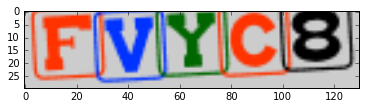

In [43]:
BSr.cv2image()

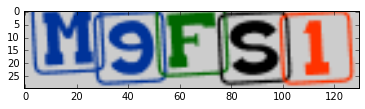

In [98]:
BSr.Captcha_preprocess()

In [109]:
BSr.postpayload(1565,'M9FS1')

1

In [ ]:
stockidt = pd.read_csv('csv_data/listcompanyo.csv',encoding='utf-8')
stockidL = stockidt['股票代號'].tolist()
fprocessed = [i.split('_')[0] for i in os.listdir('csv_data/stockdt/ori') if i.endswith('20160408.csv')==True]
unprocess = [i for i in stockidL if str(i) not in fprocessed]

In [100]:
BSr.answ

'\n\n\n交易日期\n0年02月67日\n證券代號\n1565\xa0精華"\n1050408"\n\n\n成交筆數\n179,399,985\n成交金額\n270,095&nbsp元\n成交股數\n1\n週轉率(%)\n652\n\n\n開盤價\n671.00\n最高價\n651.00  \n最低價\n666.00\n收盤價\n102.00\n\n\n'

In [110]:
BSr.ind

,0,1,2,3,4,5,6,7
0,交易日期,0年02月67日,證券代號,"1565 精華"" 1050408""",NaN,NaN,NaN,NaN
1,成交筆數,179399985,成交金額,"270,095&nbsp元",成交股數,1.0,週轉率(%),652.0
2,開盤價,671.00,最高價,651.00,最低價,666.0,收盤價,102.0


In [105]:
BSr.ind

,0,1,2,3,4,5,6,7
0,交易日期,105年04月08日,證券代號,1565 精華,NaN,NaN,NaN,NaN
1,成交筆數,267,成交金額,"179,399,985&nbsp元",成交股數,270095.0,週轉率(%),0.53
2,開盤價,652.00,最高價,671.00,最低價,651.0,收盤價,666.00


In [113]:
BSr.ind[1][0]

'0年02月67日'

In [116]:
int(re.sub('[^0-9]','/',BSr.ind[1][0]).split('/')[0:3][0])

0

In [ ]:
#檢查版面有沒有跑掉兩種條件想法1.len(self.ind[3][0]) >10 2. 交易日期第一個小於80

In [112]:
len(BSr.ind[3][0])

17

In [89]:
int(re.sub('[^0-9]','',BSr.ind[3][1]))

270095

In [18]:
BSr.csvf.text

'ㄩ坝�R芥靡ㄩΘユ基�q戈�T\r\n靡ㄩ�N�X,8349\r\n�歉�,ㄩ坝,基��,�R�i�鸭�,芥�X�鸭�,,�歉�,ㄩ坝,基��,�R�i�鸭�,芥�X�鸭�\r\n"1","1034  �g蝗古�q","79.00","0","1,000",,"2","126D  Щ环�x�n","79.20","1,000","0"\r\n"3","585Z  参�@�Q��","78.90","1,000","0",,"4","585Z  参�@�Q��","79.10","1,000","0"\r\n"5","585Z  参�@�Q��","79.20","1,000","0",,"6","585Z  参�@�Q��","79.30","1,000","0"\r\n"7","585Z  参�@�Q��","79.40","1,000","0",,"8","585Z  参�@�Q��","79.50","1,000","0"\r\n"9","6163  い�H�Uッ�d","80.00","0","1,000",,"10","6950  褐秤","79.00","10,000","0"\r\n"11","700I  ��伦�_蔼动","80.00","0","1,000",,"12","703A  �P�Mら哎","80.00","2,000","0"\r\n"13","779c  瓣布窗�_","79.10","2,000","0",,"14","815A  �x�s蔼动","79.40","0","1,000"\r\n"15","8458  �d�M�x�n","79.10","0","1,000",,"16","8561  �s���xい","79.10","2,000","0"\r\n"17","8847  ド�s�x�n","79.00","6,000","0",,"18","8849  ド�s�x�j","78.90","0","1,000"\r\n"19","9300  地�nッ��","79.00","0","3,000",,"20","9300  地�nッ��","79.10","0","2,000"\r\n"21","9300  地�nッ��","79.50","0","1,000",,"22","9321  ッ�鳕唯�","79.00",

In [25]:
ind[1][0]

'105年04月08日'

In [27]:
dtda = re.sub('[^0-9]','/',ind[1][0]).split('/')[0:3]

In [28]:
('').join(dtda)

'1050408'

In [7]:
BSr.OCR()

'GAS7R'

In [ ]:
for i in range(1000):
    BSr.Captcha_preprocess()
    print(i,'. ',BSr.OCR())
    time.sleep(1.5)

0 .  1318Q
1 .  KHHA4
2 .  XUQGU
3 .  7GXN8
4 .  NSLLS
5 .  TAGBY
6 .  
7 .  BNGQL
8 .  JHNHN
9 .  11K6U
10 .  D7MVB
11 .  INKHS
12 .  CJVDVX
13 .  92QXD
14 .  XPELX
15 .  111Q48H
16 .  NTJZC
17 .  CQ19RR
18 .  TRQR2
19 .  IEFGL
20 .  F1C3
21 .  PLTT1
22 .  1141116
23 .  
24 .  NBDIN
25 .  CY3P8
26 .  LSES
27 .  YFYZCC
28 .  VFKFY
29 .  UFNUS
30 .  ZGRFLHB
31 .  UQBS
32 .  RDUXB
33 .  1XAL
34 .  QKZD7
35 .  DEUVV
36 .  RXUL7
37 .  GLJBR
38 .  DXKQB
39 .  AK7VH
40 .  Z8FVJ2
41 .  PVKSL
42 .  XTZ1X
43 .  EZTQPU
44 .  GUFNGR
45 .  11911CK
46 .  SUBAV
47 .  87131UJ
48 .  PN934
49 .  EBXHN
50 .  NUEBZ
51 .  KIBUC
52 .  P99HZ
53 .  YTPBA
54 .  RL4QZ
55 .  IGKHA
56 .  PUSGV
57 .  YEQXC
58 .  JJLJA
59 .  C28DC
60 .  LLNSM
61 .  ADDT7
62 .  438W
63 .  5PGLZFG
64 .  34FVD
65 .  YLPB
66 .  
67 .  1YIYB
68 .  SJYP
69 .  31QD7B
70 .  BWTYM
71 .  GNTRKEG
72 .  HT1N11
73 .  HBFEG
74 .  7Y54Q
75 .  HLUSB
76 .  PDZLD
77 .  21T865
78 .  BDENN4
79 .  4VVQ6
80 .  T9N8E
81 .  QHKUK
82 .  BBJRE
83 .  CULHP


In [65]:
t = '96T10'

In [ ]:
t = 'O49Y4'

In [79]:
if '0' in t:
    print(t.replace('0','Q'))

96T1Q
